### prepair modules and bases settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.io
import re
import itertools

import os
from os.path import join
import contextlib
from copy import deepcopy
import imp 
import time 
import sys

In [2]:
# load local functions
import stim_io
import stim_io_plotting
import vtc

import Adaptation.longtrace_adaptation as longtrace_adaptation

/home/jorvhar/miniconda3/envs/predlis/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [3]:
# plotting bases settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial',
                                   "Helvetica"]
plt.rcParams['figure.dpi']= 150
sns.set_style('white')


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## General settings

In [4]:
pp = 1   # for illustation purposes
input_dir = '/media/jorvhar/Data8T/MRIData/timing data/data'

tr = 1.8
volumes = 235
nr_runs=12

In [5]:
# settings
par = scipy.io.loadmat(join(input_dir, '/media/jorvhar/Data8T/MRIData/timing data/grid_parameters.mat'))
mat = scipy.io.loadmat(join(input_dir, '{}/{}_settings_tonotopy.mat'.format(pp, pp)))
all_freqs = mat['cfg']['freq_array'][0][0][0,:]

# must match the tonotopy settings
tunsteps       = par['tunsteps'][0][0]
freqstep       = par['freqstep'][0][0]
subsample      = par['subsample'][0] - 1
mustep         = par['mustep'][0]
muarray_bins   = par['muarray'][0]
muarray        = par['muarray_bins'][0]

# check if matlab and python values are consistent
if not np.all(np.abs(np.concatenate((muarray_bins, muarray)) - np.concatenate((all_freqs, all_freqs[subsample]))) <  1e-10):
    print('Warning; matlab and python muarray values inconsistent')

# tuning sizes
fwhm           = par['fwhm'][0]    #HIERGEBLEVEN \/
octgrid        = par['octgrid'][0]
sigmagrid      = par['real_sigma'][0]

# set range of tunings and sharpnesses
pref_range  = muarray                # match t
sharp_range_fwhm = fwhm              # sharp range in octaves
sharp_range = sigmagrid                # check if correct, fwhm or sigma of gaussian?

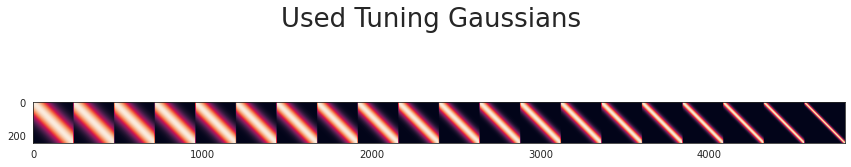

In [6]:
ax, fig = stim_io_plotting.freqs_plot(pref_range, sharp_range)
# check consistantcy with matlab
if not np.all(np.abs(ax.get_images()[0].get_array().data - par['W']) < 1e-10):
    print('Warning; W-array from Matlab inconsistant with generated figure')

# Loading LogData and Modelling Stim-Responses
Code to loop over participants and runs, loading in the desired data, and adding model responses for Expectations and Adaptation. Additionally responses are convolved to get results closer to the fMRI-like response behaviour. Responses are eventually saved as a preprocessed dataframe.

#### i. generate .mat files / run drex matlab model

In [8]:
## define all participants and nr of runs of that pp
ppz = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
nr_runs = [12, 12, 10, 10, 10, 10, 10, 10, 10, 10]

## create drex matfiles for all pps
for pp_idx in range(len(ppz)):
    
    # sellect pp
    pp = ppz[pp_idx]
    runs = nr_runs[pp_idx]
    
    # calculate dataframes for current participant
    puls_df = stim_io.pulses_load(str(pp), input_dir, runs)
    volumes_df = stim_io.volumes_load(puls_df, tr, volumes, nr_runs=runs)
    mat, stimuli = stim_io.data_load(str(pp), join(input_dir, str(pp)))
    stim_df = stim_io.stims_load(puls_df, volumes_df, mat, stimuli)
    
    # and export to .mat to run drex
    stim_io.stims_export_mat(str(pp), input_dir, stim_df, pref_range)
    stim_io.run_drex(str(pp), input_dir) # only have to do this once

#### ii. fit stim model results within dataframe

In [18]:
## define all participants and nr of runs of that pp
ppz = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
nr_runs = [12, 12, 10, 10, 10, 10, 10, 10, 10, 10]

# adaptation decay settings
x_decay, y_decay = longtrace_adaptation.double_exp_decay_func(0.1399, 0.85, 0.0345, 6.82, [1, 10], 1)

# cononical hrf
hrf = scipy.io.loadmat('/media/jorvhar/Data8T/MRIData/timing data/hrf.mat')

## create drex matfiles for all pps
for pp_idx in range(len(ppz)):
    
    # sellect pp
    pp = ppz[pp_idx]
    runs = nr_runs[pp_idx]
    print(f'Sub: {pp} (nr_runs: {runs})')
    
    # -------------------------------------------------- #
    ## 1. Loading in the log-data from experimental file #
    puls_df = stim_io.pulses_load(str(pp), input_dir, runs)
    volumes_df = stim_io.volumes_load(puls_df, tr, volumes, nr_runs=runs)
    mat, stimuli = stim_io.data_load(str(pp), join(input_dir, str(pp)))
    stim_df = stim_io.stims_load(puls_df, volumes_df, mat, stimuli)
    
    # -------------------------------------------------- #
    ## 2a. Add D-Rex to dataframe (pre-saved)            #
    stim_df = stim_io.stims_add_drex(str(pp), input_dir, stim_df)
    ## 2b. Add trial level adaptation                    #
    activations, adaptations, adapted_activations, n_back_adaptations = stim_io.run_adaptation(stim_df, 
                                                                                               pref_range, 
                                                                                               sharp_range, 
                                                                                               y_decay)
    stim_df = stim_io.stims_add_adaptation(stim_df, 
                                           pref_range, 
                                           sharp_range, 
                                           activations, 
                                           1-adaptations,       # take 1-adaptation to make filling with 0s possible
                                           adapted_activations)
    del activations, adaptations, adapted_activations, n_back_adaptations # cleanup vars for memory
    
    # ------------------------------------------------------- #
    ## 3. Trasnsfer stim_df from stimulus domain to TR domain #
    
    # main function for adding timesteps (inbetween runs, / blocks)
    stim_df = stim_io.stims_add_temporal_pad(stim_df, volumes_df)
    # convolve stim_df with hrf (the regressors)
    newhrf = stim_io.con_hrf_stimdomain(hrf, stim_df, plotres=False)
    stim_df = stim_io.stims_convolve_hrf(stim_df, newhrf)
    # to get dataframe in tr space
    tr_df = stim_io.stims_to_tr(stim_df, volumes_df, downsample_unconv=True) # was False
    
    # ---------------------------------------- #
    ## 4. Save dataframes to file              #
    stim_io.save_df(stim_df, input_dir, pp, fn='processed_df_stim')
    stim_io.save_df(tr_df, input_dir, pp, fn='processed_df_tr')
    # stim_df = stim_io.load_df(input_dir, pp, fn='processed_df_stim') # loading
    # tr_df = stim_io.load_df(input_dir, pp, fn='processed_df_tr') # loading

Sub: 1 (nr_runs: 12)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


Sub: 2 (nr_runs: 12)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


Sub: 3 (nr_runs: 10)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


Sub: 4 (nr_runs: 10)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


Sub: 5 (nr_runs: 10)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


Sub: 6 (nr_runs: 10)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


Sub: 7 (nr_runs: 10)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


Sub: 8 (nr_runs: 10)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


Sub: 9 (nr_runs: 10)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


Sub: 10 (nr_runs: 10)


/media/jorvhar/Data1/OneDrive_Mint/Documenten/Maastricht/processing_scripts/predadapt_fmri/ses2_modelstims/stim_io.py:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['onoff'] = df['frequencies'].notna().astype(float)


# Ilustrating Results

Below example code with sanity check figures showing the procedure of loading individual participants and plotting each step of the expending dataframe. Starting with loading of LogData, applying DREX modelling and adaptation modelling to them.

## 1. Load the data
### a. stimuli data

In [21]:
puls_df = stim_io.pulses_load(str(pp), input_dir, 10)
volumes_df = stim_io.volumes_load(puls_df, tr, volumes, nr_runs=10)

mat, stimuli = stim_io.data_load(str(pp), join(input_dir, str(pp)))
stim_df = stim_io.stims_load(puls_df, volumes_df, mat, stimuli)

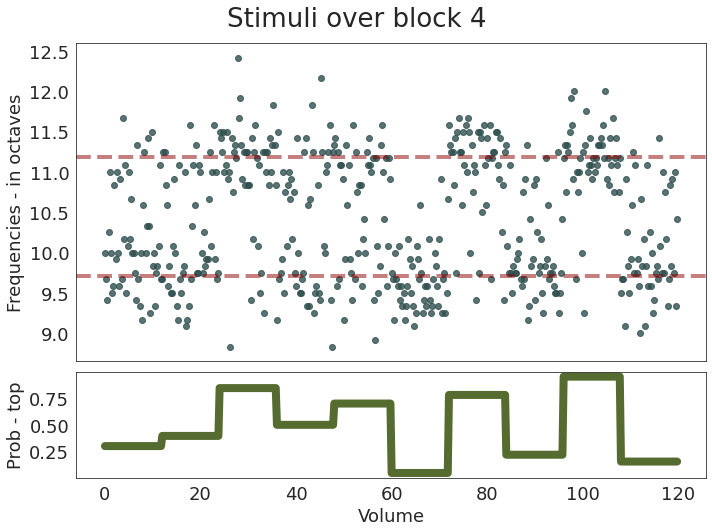

In [8]:
ax, fig = stim_io_plotting.data_plot(mat, stimuli, blocknr=4, octvspace=True)

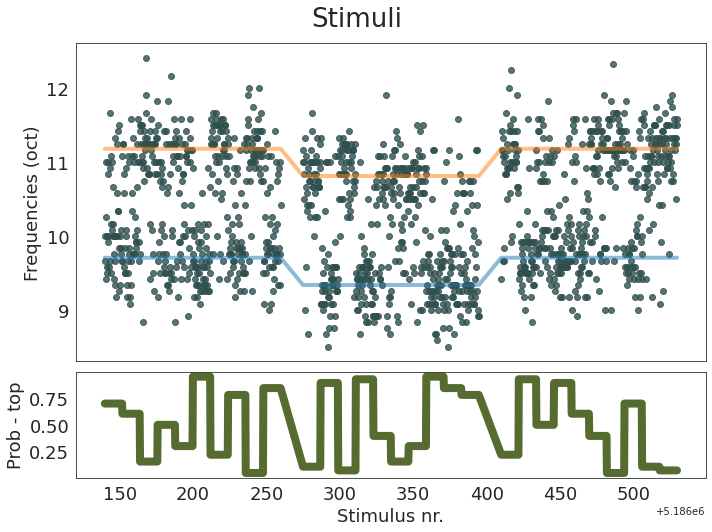

In [9]:
df = stim_df[stim_df['run'] == 2]
ax, fig = stim_io_plotting.stim_plot(df)

### b. add DREX data

#### ii. fit mat files to dataframe

In [22]:
stim_df = stim_io.stims_add_drex(str(pp), input_dir, stim_df)


### THIS ADD DREX IS CURRENTLY ONLY FOR ONE PARTICIPANT, WE NEED TO LATER LOOP OVER PARTICIPANTS AND RUNS, 
### AND FIT THIS IN

<AxesSubplot:>

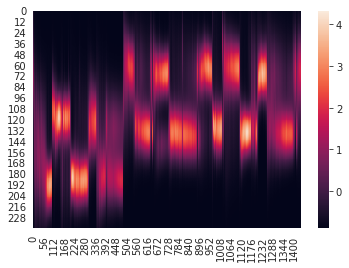

In [23]:
# quick senity check figure of predicted probability
run = 5
predprobz = stim_df[stim_df['run'] == run].filter(regex='pred_prob[_0-9.]+').to_numpy()

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
predprobz = (predprobz - predprobz.mean()) / predprobz.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

sns.heatmap( predprobz.transpose() )

### c. add adaptation data

In [24]:
import Adaptation.longtrace_adaptation as longtrace_adaptation
x_decay, y_decay = longtrace_adaptation.double_exp_decay_func(0.1399, 0.85, 0.0345, 6.82, [1, 10], 1)

activations, adaptations, adapted_activations, n_back_adaptations = stim_io.run_adaptation(stim_df, 
                                                                                           pref_range, 
                                                                                           sharp_range, 
                                                                                           y_decay)
stim_df = stim_io.stims_add_adaptation(stim_df, 
                                       pref_range, 
                                       sharp_range, 
                                       activations, 
                                       1-adaptations,       # take 1-adaptation to make filling with 0s possible
                                       adapted_activations)

# cleanup collumns
del activations, adaptations, adapted_activations, n_back_adaptations

In [ ]:
### SAME FOR ADAPTATION, WE NEED TO LOOP OVER PARTICIPANTS AND ACTUALLY FIT IT FOR EACH STIM_DF

<AxesSubplot:>

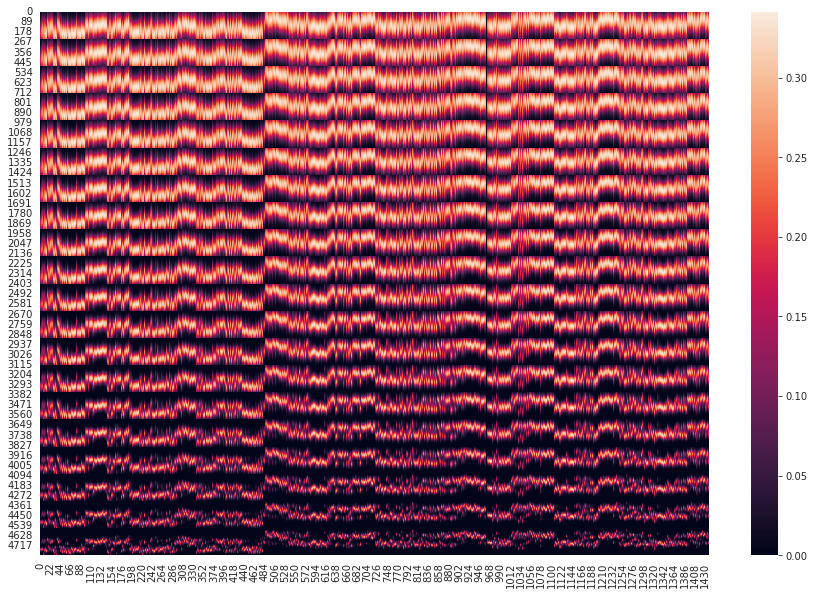

In [26]:
# quick senity check
run = 5
activs = stim_df[stim_df['run'] == run].filter(regex='adapt_[_0-9.]+').to_numpy()

fig, ax = plt.subplots(1,1, figsize=(15,10))

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
#activs = (activs - activs.mean()) / activs.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

sns.heatmap( activs.transpose() )

<AxesSubplot:>

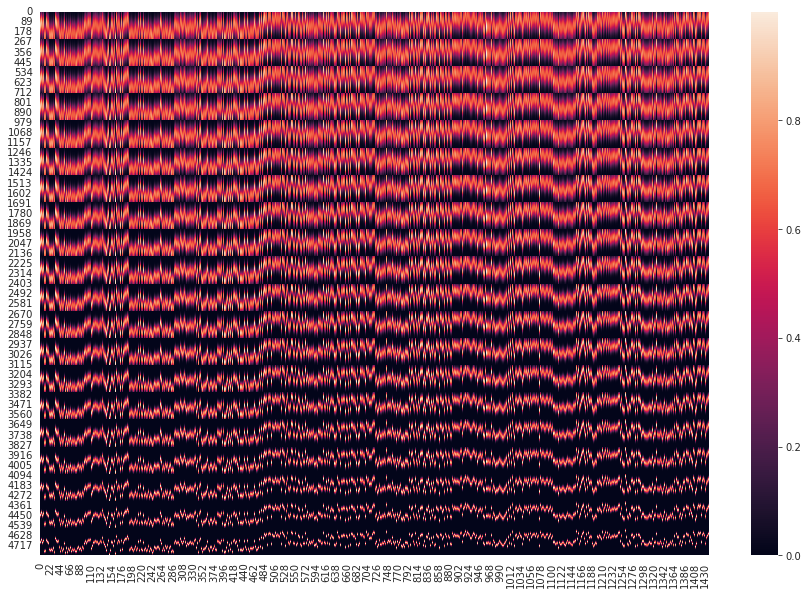

In [27]:
# quick senity check
run = 5
activs = stim_df[stim_df['run'] == run].filter(regex='activ_[_0-9.]+').to_numpy()

fig, ax = plt.subplots(1,1, figsize=(15,10))

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
#activs = (activs - activs.mean()) / activs.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

sns.heatmap( activs.transpose() )

## 2. TR domain transfer

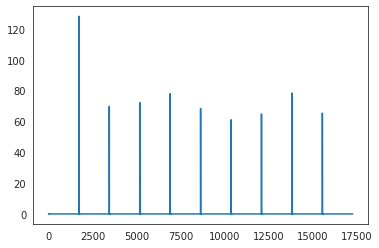

In [18]:
# main function for adding timesteps (inbetween runs, / blocks)
stim_df = stim_io.stims_add_temporal_pad(stim_df, volumes_df)

# sanity check timing diffs
plt.plot(stim_df['timing'].diff())

In [19]:
# load cononical hrf
hrf = scipy.io.loadmat('/media/jorvhar/Data8T/MRIData/timing data/hrf.mat')
newhrf = stim_io.con_hrf_stimdomain(hrf, stim_df, plotres=False)

# convolve stim_df with hrf (the regressors)
stim_df = stim_io.stims_convolve_hrf(stim_df, newhrf)

In [20]:
# to get dataframe in tr space, simply 
# then, when we want to do the FIR, we can do this groupby sum approach, and take the non-convolved, and shift() some steps
  #tr_df = stim_df.groupby(['volume_abs']).sum()
    
tr_df = stim_io.stims_to_tr(stim_df, volumes_df, downsample_unconv=False)

In [374]:
print(f'Prefrange: \n {np.round(pref_range,4)}\n\nSharprange: \n {np.round(sharp_range,4)}')

p = pref_range[30]
t = sharp_range[5]

stim_io.get_tw_collumns(tr_df, p, t, convolved=True)

Prefrange: 
 [ 7.6439  7.6644  7.6849  7.7054  7.726   7.7465  7.767   7.7876  7.8081
  7.8286  7.8492  7.8697  7.8902  7.9108  7.9313  7.9518  7.9724  7.9929
  8.0134  8.0339  8.0545  8.075   8.0955  8.1161  8.1366  8.1571  8.1777
  8.1982  8.2187  8.2393  8.2598  8.2803  8.3008  8.3214  8.3419  8.3624
  8.383   8.4035  8.424   8.4446  8.4651  8.4856  8.5062  8.5267  8.5472
  8.5677  8.5883  8.6088  8.6293  8.6499  8.6704  8.6909  8.7115  8.732
  8.7525  8.7731  8.7936  8.8141  8.8346  8.8552  8.8757  8.8962  8.9168
  8.9373  8.9578  8.9784  8.9989  9.0194  9.04    9.0605  9.081   9.1016
  9.1221  9.1426  9.1631  9.1837  9.2042  9.2247  9.2453  9.2658  9.2863
  9.3069  9.3274  9.3479  9.3685  9.389   9.4095  9.43    9.4506  9.4711
  9.4916  9.5122  9.5327  9.5532  9.5738  9.5943  9.6148  9.6354  9.6559
  9.6764  9.6969  9.7175  9.738   9.7585  9.7791  9.7996  9.8201  9.8407
  9.8612  9.8817  9.9023  9.9228  9.9433  9.9639  9.9844 10.0049 10.0254
 10.046  10.0665 10.087  10.1076 10.128

['pred_prob_8.260_convolved',
 'raw_acti_8.260_1.010_convolved',
 'raw_adapt_8.260_1.010_convolved',
 'adapt_activ_8.260_1.010_convolved',
 'surprisal_convolved',
 'onoff_convolved']

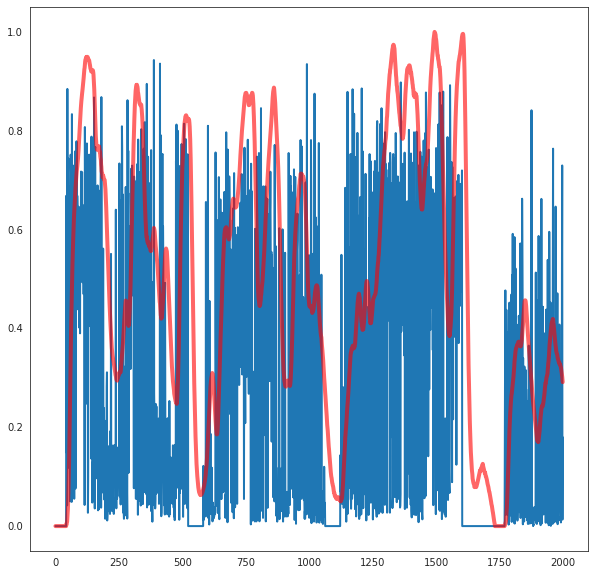

In [52]:
# check if worked
start = 0
end = 2000
ax, fig = plt.subplots(1, 1, figsize=(10,10))
plt.plot(stim_df[f'adapt_activ_{p:.3f}_{t:.3f}'][start:end], lw=2)
plt.plot(stim_io.normalize(stim_df[f'adapt_activ_{p:.3f}_{t:.3f}_convolved'][start:end]),color='r', alpha=0.6, lw=4)

In [373]:
tr_df

,frequencies,frequencies_oct,timing,closest_volume_rel,closest_volume_abs,volume_rel,volume_abs,run,block,segment,...,adapt_activ_12.407_0.181_resampled,adapt_activ_12.428_0.181_resampled,adapt_activ_12.448_0.181_resampled,adapt_activ_12.469_0.181_resampled,adapt_activ_12.489_0.181_resampled,adapt_activ_12.510_0.181_resampled,adapt_activ_12.530_0.181_resampled,adapt_activ_12.551_0.181_resampled,surprisal_resampled,onoff_resampled
0,NaN,NaN,5.185610e+06,0,0,0,0,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,5.185612e+06,0,0,1,1,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,5.185614e+06,1,1,2,2,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,5.185616e+06,2,2,3,3,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,5.185618e+06,3,3,4,4,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,NaN,NaN,5.191579e+06,229,2814,230,2815,12.0,36.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2816,NaN,NaN,5.191581e+06,230,2815,231,2816,12.0,36.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2817,NaN,NaN,5.191583e+06,231,2816,232,2817,12.0,36.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2818,NaN,NaN,5.191585e+06,232,2817,233,2818,12.0,36.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


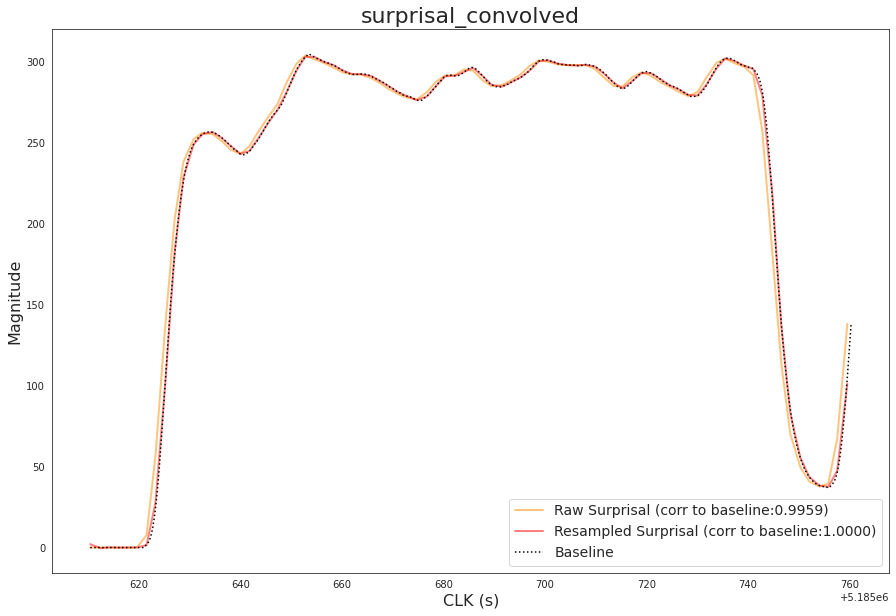

(<AxesSubplot:title={'center':'surprisal_convolved'}, xlabel='CLK (s)', ylabel='Magnitude'>,
 <Figure size 1080x720 with 1 Axes>)

In [17]:
# plotting tr domain transformation, naive mean appraoch vs resampling approach
stim_io_plotting.resample_plot(tr_df, stim_df, 'surprisal_convolved',timing=2000)

In [23]:
stim_df[stim_df['frequencies'].notnull()]

,frequencies,frequencies_oct,timing,closest_volume_rel,closest_volume_abs,volume_rel,volume_abs,run,block,segment,...,adapt_activ_12.407_3.397_convolved,adapt_activ_12.428_3.397_convolved,adapt_activ_12.448_3.397_convolved,adapt_activ_12.469_3.397_convolved,adapt_activ_12.489_3.397_convolved,adapt_activ_12.510_3.397_convolved,adapt_activ_12.530_3.397_convolved,adapt_activ_12.551_3.397_convolved,surprisal_convolved,onoff_convolved
43,542.445104,9.083333,2.514616e+06,5,5,5,5,1.0,1.0,1.0,...,0.047253,0.046974,0.046694,0.046415,0.046135,0.045856,0.045576,0.045297,0.964919,0.076256
44,287.350284,8.166667,2.514616e+06,5,5,6,6,1.0,1.0,1.0,...,0.069497,0.069058,0.068619,0.068180,0.067742,0.067304,0.066866,0.066429,1.680087,0.138041
45,322.539789,8.333333,2.514616e+06,5,5,6,6,1.0,1.0,1.0,...,0.103321,0.102675,0.102028,0.101382,0.100736,0.100090,0.099445,0.098800,2.510009,0.211297
46,456.140144,8.833333,2.514617e+06,5,5,6,6,1.0,1.0,1.0,...,0.160680,0.159716,0.158752,0.157787,0.156823,0.155859,0.154895,0.153931,3.785254,0.318462
47,645.079578,9.333333,2.514617e+06,5,5,6,6,1.0,1.0,1.0,...,0.247487,0.246060,0.244633,0.243205,0.241777,0.240347,0.238918,0.237488,5.741628,0.478473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17150,2896.309376,11.500000,2.519578e+06,216,2331,217,2332,10.0,30.0,10.0,...,15.969477,15.947366,15.924904,15.902090,15.878924,15.855406,15.831536,15.807314,282.904019,25.498072
17151,2169.780417,11.083333,2.519578e+06,216,2331,217,2332,10.0,30.0,10.0,...,15.977040,15.955049,15.932706,15.910012,15.886967,15.863569,15.839820,15.815719,282.818190,25.498072
17152,2580.318310,11.333333,2.519578e+06,217,2332,217,2332,10.0,30.0,10.0,...,15.987742,15.965928,15.943762,15.921245,15.898376,15.875155,15.851582,15.827656,282.856217,25.498072
17153,2896.309376,11.500000,2.519579e+06,217,2332,217,2332,10.0,30.0,10.0,...,15.998660,15.977028,15.955045,15.932710,15.910023,15.886985,15.863594,15.839851,282.951150,25.498072


In [24]:
# fig, ax = plt.subplots(2, 
#                        1, 
#                        sharex=True,
#                        gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,  7.5))

# tempdf = stim_df[tr_df['run'].isin(np.arange(1,2,1))]

# ax[0].scatter(tempdf['timing'], tempdf['frequencies_oct'], color='darkslategrey', alpha=0.8)

In [53]:
tempdf = tr_df[tr_df['run'].isin(np.arange(1,2,1))]

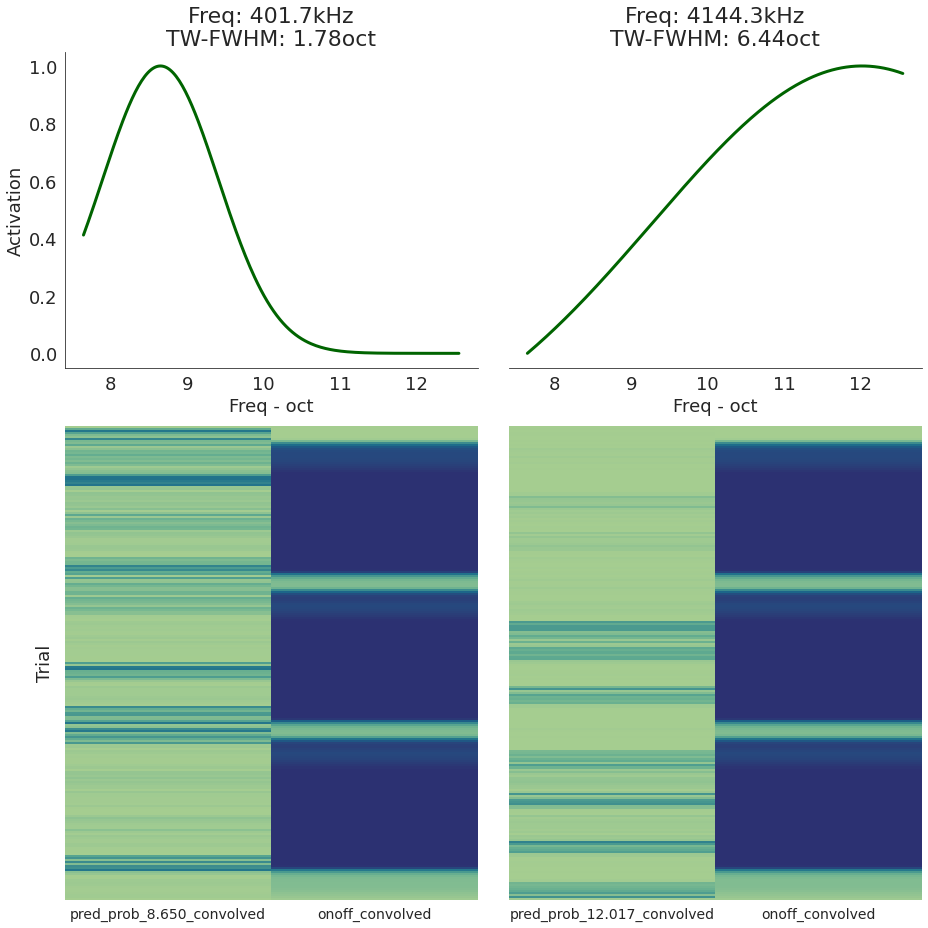

In [54]:
pref1 = 8.6499
pref2 = 12.0169

tw1 = 0.755
tw2 = 2.7367

col_oi = ['pred', 'raw_adapt', 'onoff_con']

ax, fig = stim_io_plotting.plot_design_mat(tr_df, all_freqs, pref1, tw1, pref2, tw2, runs=np.arange(1,2,1),
                                          prefixes= col_oi)
# ax, fig = stim_io_plotting.plot_design_mat(tr_df, all_freqs, pref1, tw1, pref2, tw2, runs=np.arange(1,7,1))